# 1. Overview
Dermatoscopy is a diagnostic technique that can improve the diagnosis of benign and malignant pigmented skin lesions. Other than increasing the accuracy of skin cancer detection (if compared to naked eye exams), dermatoscopic images can also be used to train ANN. In the past, promising attempts have been made to use ANN to classify skin lesions. However, the lack of data and computing power limited the application of this method.

As mentioned by the authors, the original paper and release of HAM10000 aimed to boost the research on the automated diagnosis of dermatoscopic images. We can say they have certainly achieved that goal after three successful challenges and an impressive expansion of the database.

## 1.1. Content ##

The HAM10000 dataset is composed of 10.015 dermatoscopic images of seven types of pigmented skin lesions:

Actinic Keratoses (akiec) - 327 <br>
Basal Cell Carcinoma (bcc) - 514<br>
Benign keratosis-like lesions(bkl) - 600<br>
Dermatofibroma (df) - 126<br>
Melanoma (mel) - 1113<br>
Vascular lesions (vasc) - 142<br>
Melanocytic nevi (nv) - 6705

The data was collected from Australian and Austrian patients. Two institutions participated in providing the images: Cliff Rosendahl in Queensland, Australia, and Medical University of Vienna, Austria. According to the authors, seven classes are defined on this dataset where some diagnosis were unified into one class for simplicity. Information regarding patient age, sex, lesion location and diagnosis is also provided with each image.

## 1.2. Acknowledgements ##

The dataset has been collated and published by [Philipp Tschandl, Rosendahl, C., & Kittler, H.](https://www.nature.com/articles/sdata2018161) and all credits go to them.

In [1]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image


# 2. The Data

In this section, we analyse our metadata and understand a bit more regarding the patients and dataset distribution.

## Key Insights

* Small number of Missing Values, only for Age features where replacement with most frequent value was used
* Similar distribution between Males and Females
* Melanocytic nevi is the dominant class in the dataset (67%). It could result in a bias towards this type of os skin lesion
* Most samples are from patients within 35 - 60 yrs old
* Melanoma, malignant skin lesion, seems to be more common in the ages of 45 to 70. Males represent 62% of the incidence of this type of lesion



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import shutil

os.chdir('/content/drive/MyDrive/FYP/data')
base_skin_dir = os.getcwd() + "/reorganized/"
skin_df = pd.read_csv('HAM10000_metadata.csv')

In [4]:
# Display the first few rows of the dataset
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# Check the structure of the dataset
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [6]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    return summary


In [7]:
#Read File csv
skin_df = pd.read_csv('HAM10000_metadata.csv')

In [8]:
# Unique values of 'dx' column (diagnosis)
unique_dx = skin_df['dx'].unique()
print("Unique values of 'dx' column (diagnosis):", unique_dx)

Unique values of 'dx' column (diagnosis): ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [9]:
#Lesion Dictionary
lesion_type_dict = {
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
}

# base_skin_dir = os.path.join('..', 'input','skin-lesions-act-keratosis-and-melanoma/ISIC-images')
#Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*.jpg'))}

#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

The CSV file contains originally seven features. In the code lines above we add 3 extra columns to support the data analysis and facilitate the extraction of images later on.

In [10]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/.shortcut-targets-by-id/1lclS-j...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/.shortcut-targets-by-id/1lclS-j...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/.shortcut-targets-by-id/1lclS-j...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/.shortcut-targets-by-id/1lclS-j...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/.shortcut-targets-by-id/1lclS-j...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/content/drive/.shortcut-targets-by-id/1lclS-j...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/content/drive/.shortcut-targets-by-id/1lclS-j...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/content/drive/.shortcut-targets-by-id/1lclS-j...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/content/drive/.shortcut-targets-by-id/1lclS-j...,Actinic keratoses,0


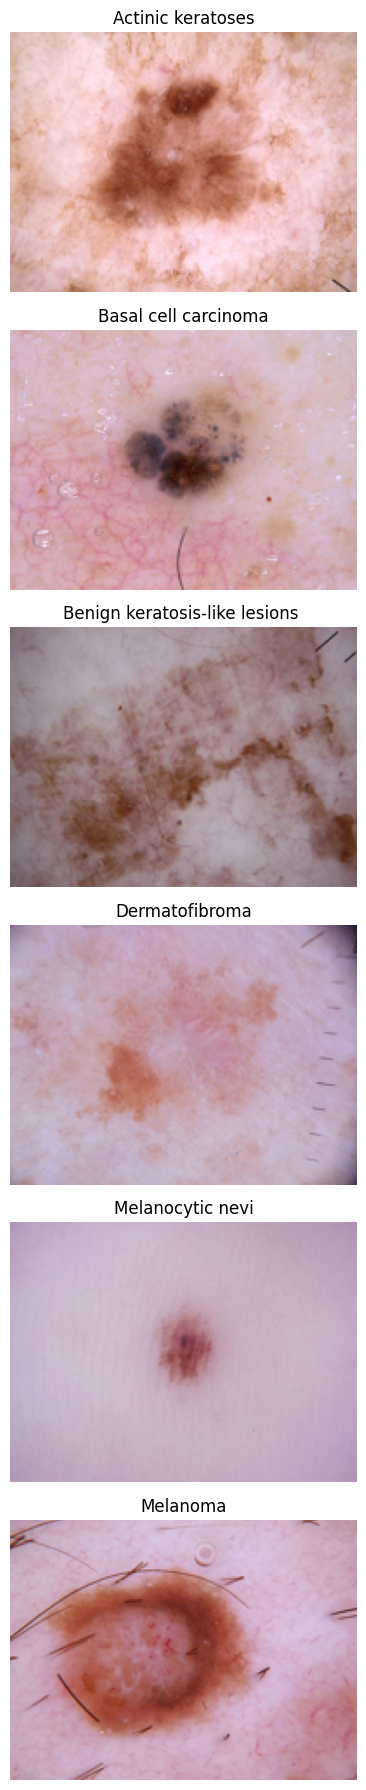

In [14]:
img = skin_df.groupby('cell_type').apply(lambda x: x.sample(n=1)).reset_index(drop=True)
img['image'] = img['path'].map(lambda x: np.asarray(Image.open(x).resize((200, 150))))

# Image Sampling
n_samples = 1

fig, m_axs = plt.subplots(6, n_samples, figsize=(4 * n_samples, 3 * 6))

for n_axs, (_, c_row) in zip(m_axs, img.iterrows()):
    ax = n_axs
    ax.imshow(c_row['image'])
    ax.axis('off')
    ax.set_title(c_row['cell_type'], fontsize=12)

plt.tight_layout()
plt.show()


Basic EDA

In [15]:
basic_EDA(skin_df)

Number of Samples: 10015,
Number of Features: 10,
Duplicated Entries: 0,
Null Entries: 57,
Number of Rows with Null Entries: 57 0.6%


Summary Table

In [16]:
summary_table(skin_df)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15
7,path,object,0,10015
8,cell_type,object,0,7
9,cell_type_idx,int8,0,7


The summary helps to understand the type of metadata collected. The Uniques indicate the number of unique for each feature


We noticed that for some lesions there must be more than one image as the lesion and image ID do not match. The discrepancy between the number of unique values in the 'lesion_id' column (7470) and the number of unique values in the 'image_id' column (10015) suggests that multiple images may belong to the same lesion.
- In medical imaging datasets like HAM10000, it's common for multiple images to be taken of the same lesion from different angles or under different conditions (e.g., different lighting, magnification levels, or imaging modalities).
- Each of these images would have a unique 'image_id', but they would share the same 'lesion_id'.

 The null entries are only related to the Age feature, as such no major data cleanse is required as the dataset is pretty much ready to use.

In [17]:
#Bit of Data Cleanse
#NaN Values
skin_df['age'].fillna(skin_df['age'].mode(),inplace=True)

## Unique value of features

From the summary table's Uniques columns, we discovered the number of classes (dx = 7), and how the sex and localization features were organized. Now let's find out unique value for each of them

In [18]:
# Unique values of 'dx_type' column (diagnosis type)
unique_dx_type = skin_df['dx_type'].unique()
print("Unique values of 'dx_type' column (diagnosis type):")
for value in unique_dx_type:
    print("-", value)

# Unique values of 'sex' column
unique_sex = skin_df['sex'].unique()
print("Unique values of 'sex' column:")
for value in unique_sex:
    print("-", value)

# Unique values of 'localization' column
unique_localization = skin_df['localization'].unique()
print("Unique values of 'localization' column:")
for value in unique_localization:
    print("-", value)


Unique values of 'dx_type' column (diagnosis type):
- histo
- consensus
- confocal
- follow_up
Unique values of 'sex' column:
- male
- female
- unknown
Unique values of 'localization' column:
- scalp
- ear
- face
- back
- trunk
- chest
- upper extremity
- abdomen
- unknown
- lower extremity
- genital
- neck
- hand
- foot
- acral


The catergories for 'dx_type' column are as follows:

Histopathology (Histo): Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists.

Confocal: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level, and some facial benign keratoses were verified by this method

Follow-up: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years we accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions. The presence of change was assessed by author HK who has more than 20 years of experience in digital dermatoscopic follow-up

Consensus: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

Information taken from from the relevant paper.

## Distribution

### Class Distribution

In [ ]:
print(skin_df['cell_type'].value_counts())

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64


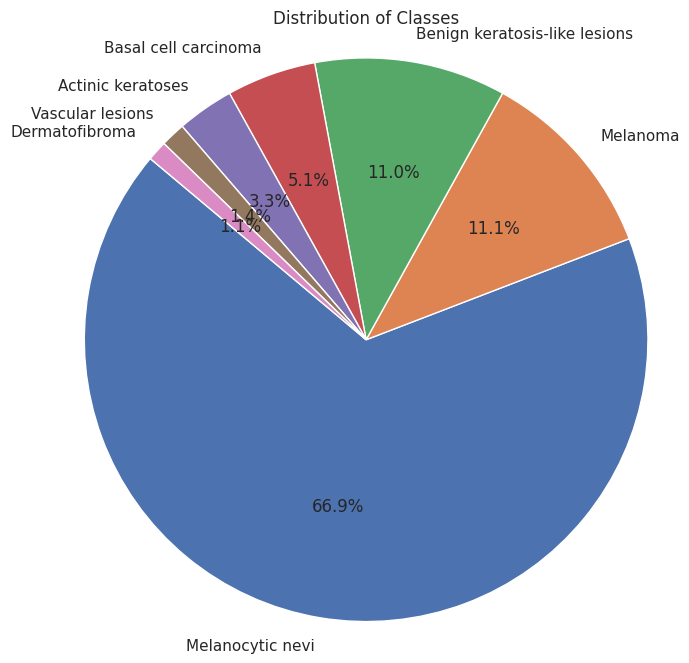

In [ ]:
import matplotlib.pyplot as plt
class_distribution = skin_df['cell_type'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


This dataset shows a seriously imbalanced class distribution.
It contains the majority of samples from the malignant form of skin lesion, Melanocytic nevi.
Dermatofibroma and Vascular Lesions are the least represented cases.

### Diagnosis Type Distribution

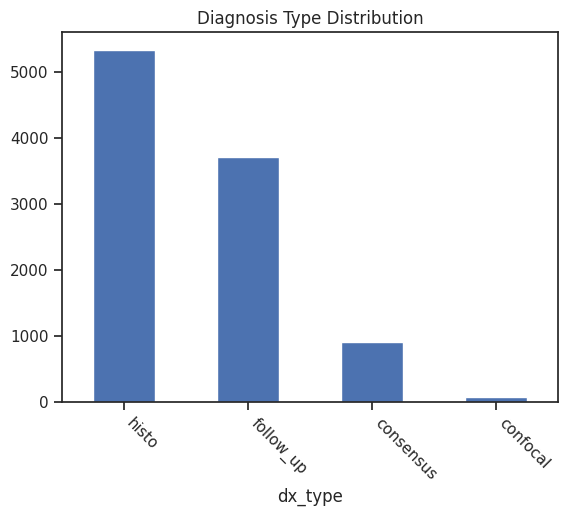

In [ ]:
import matplotlib.pyplot as plt
ax = skin_df['dx_type'].value_counts().plot(kind='bar')
plt.title('Diagnosis Type Distribution')
plt.xticks(rotation=-45, ha='left')

plt.show()

Most of the lesions are confirmed through histopathology. The remainder is verified through follow-up examination, expert consensus, or in-vivo confocal microscopy.

### Localization Distribution

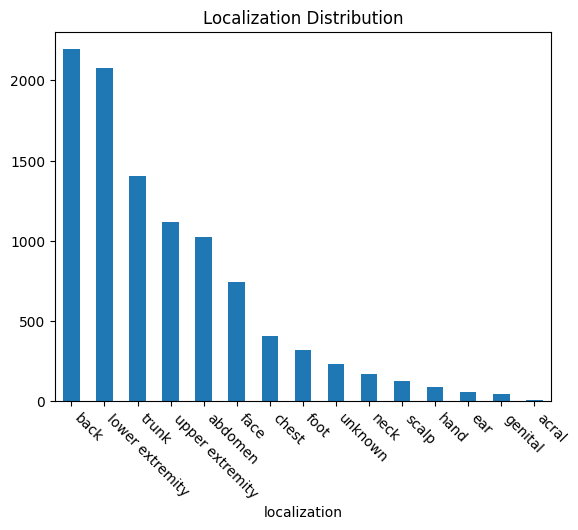

In [19]:
import matplotlib.pyplot as plt

# Create the bar plot for localization value counts
ax = skin_df['localization'].value_counts().plot(kind='bar')

# Add title to the plot
plt.title('Localization Distribution')

# Adjust x-axis tick labels rotation
plt.xticks(rotation=-45, ha='left')

# Show the plot
plt.show()


From the bar chart above, back, lower extremity, trunk, upper extremity and abdoment are the most heavily affected areas for skin cancer in this dataset

### Gender Distribution

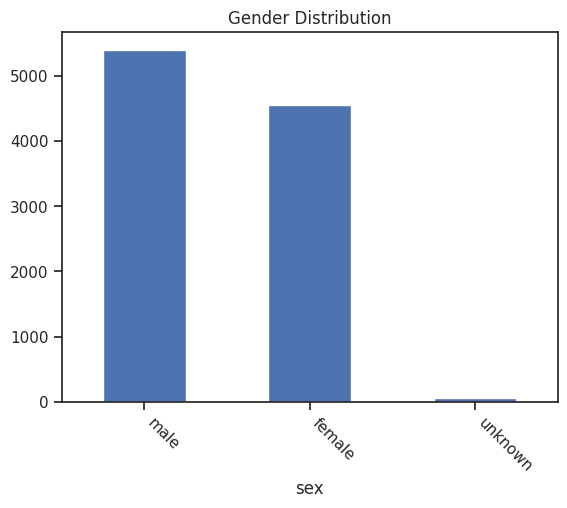

In [ ]:
import matplotlib.pyplot as plt
ax = skin_df['sex'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xticks(rotation=-45, ha='left')

plt.show()

The samples are mostly Male participants, not a significant difference between Genders

### Age Distribution

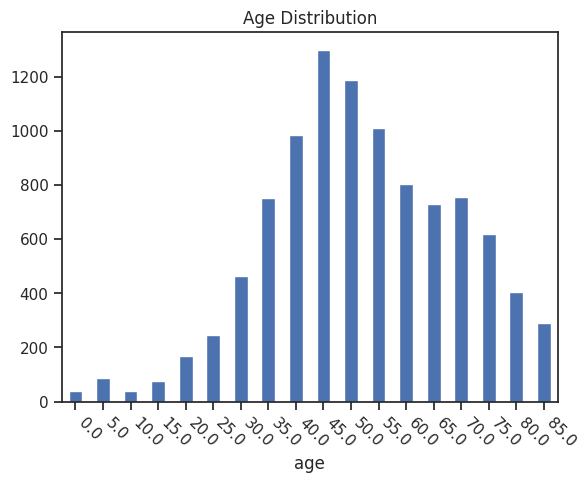

In [ ]:
import matplotlib.pyplot as plt

# Get the age value counts and sort them
age_counts_sorted = skin_df['age'].value_counts().sort_index()

# Create the bar plot for age value counts
ax = age_counts_sorted.plot(kind='bar')

# Add title to the plot
plt.title('Age Distribution')

# Adjust x-axis tick labels rotation
plt.xticks(rotation=-45, ha='left')

# Show the plot
plt.show()


- The samples are mainly from patients within 40 - 55 years old
-The number of samples rises sharply after 25 years old, doubling the samples for 30 years old and almost doubling again for 35 years old
-Between the ages of 60 - 70 years old the number of samples remain almost stable, returning to the downward trend after 75 years old

## Feature Analysis by Each Lesion Type

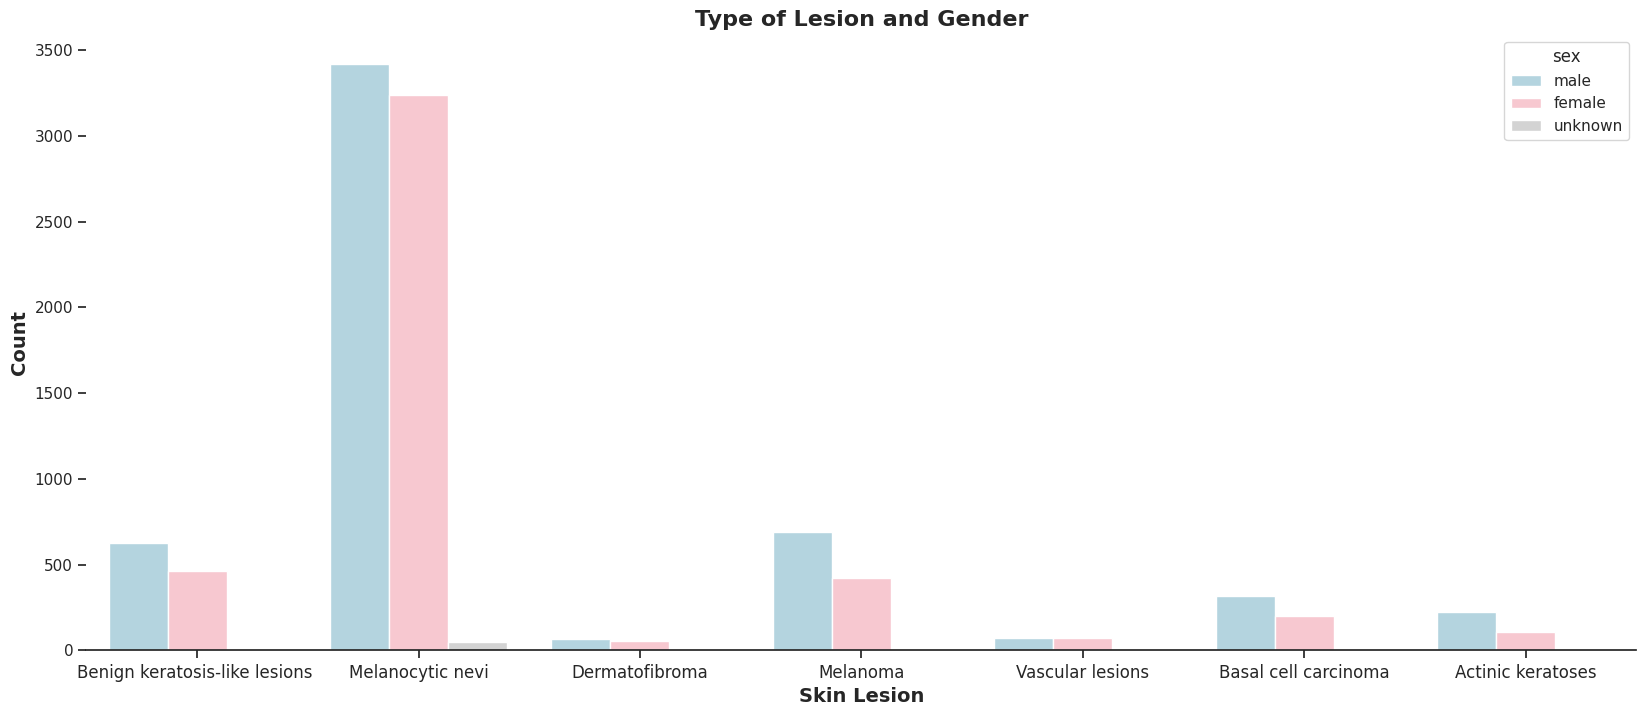

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
custom_palette = {'male': 'lightblue', 'female': 'pink', 'unknown': 'lightgrey'}

# Set the figure size
plt.figure(figsize=(20, 8))

# Set the style and font scale
sns.set(style="ticks", font_scale=1)

# Create the count plot with the custom palette
ax = sns.countplot(data=skin_df, x='cell_type', palette=custom_palette, hue='sex')

# Remove spines
sns.despine(top=True, right=True, left=True, bottom=False)

# Set x-axis labels rotation and font size
plt.xticks(rotation=0, fontsize=12)

# Set x-axis and y-axis labels
ax.set_xlabel('Skin Lesion', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')

# Set title
plt.title('Type of Lesion and Gender', fontsize=16, weight='bold')

# Show the plot
plt.show()


- Upon inspection, we notice that some diagnoses have a greater difference between male and female, namely diagnosis akiec, bcc, bkl, and mel.
- This may indicate that certain type of cancer diagnosis are more prevalent with males than females.
- However, we should be wary of this conclusion as the results we see may be a reflection of the distribution in the broader dataset (i.e., there are more skin lesions of males than females, so naturally, there will be more male examples or we haven’t collected enough examples of a certain diagnosis) or bias in the data (i.e., there’s more male or males are more likely to get screen in the population the data is from).

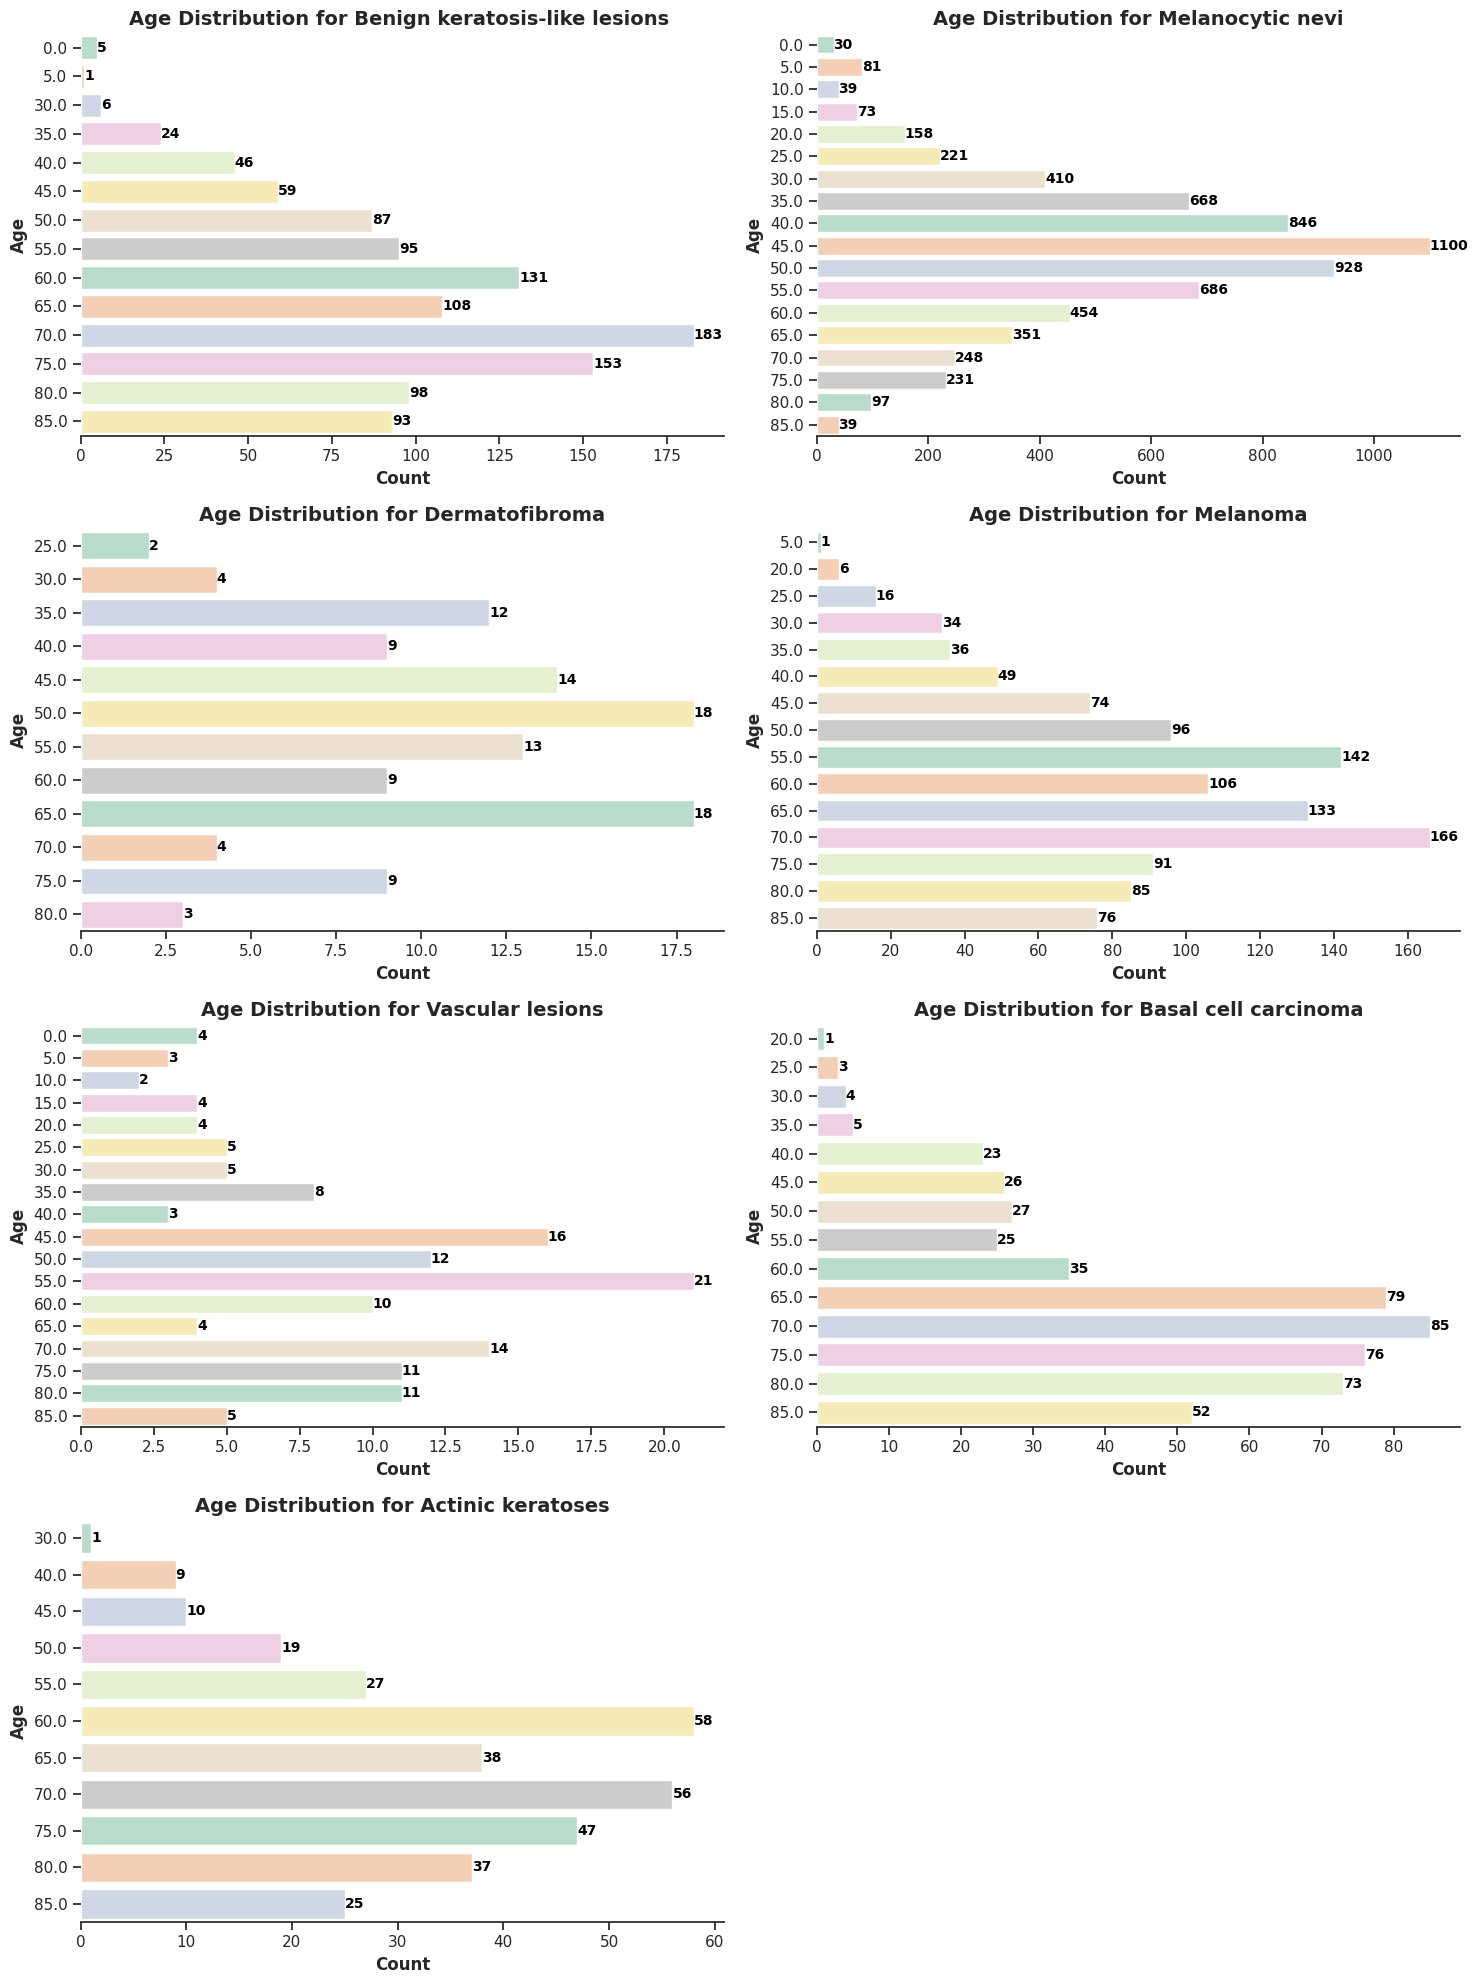

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique cell types
unique_cell_types = skin_df['cell_type'].unique()

# Calculate the number of rows and columns for subplots
num_rows = (len(unique_cell_types) + 1) // 2  # Add 1 to ensure at least one row
num_cols = min(2, len(unique_cell_types))  # Maximum 2 columns

# Set the figure size
plt.figure(figsize=(15, 5 * num_rows))

# Set the style and font scale
sns.set(style="ticks", font_scale=1)

# Iterate through each cell type
for i, cell_type in enumerate(unique_cell_types):
    # Filter data for the current cell type
    data_subset = skin_df[skin_df['cell_type'] == cell_type]

    # Create subplot
    plt.subplot(num_rows, num_cols, i + 1)

    # Create a horizontal bar plot
    ax = sns.countplot(y='age', hue='age', data=data_subset, palette='Pastel2', orient='horizontal', legend=False)

    # Add count labels on top of each bar
    for p in ax.patches:
        width = p.get_width()
        ax.text(width, p.get_y() + p.get_height()/2., '{:.0f}'.format(width), ha="left", va="center", fontsize=10, color='black', weight='bold')

    # Remove spines
    sns.despine(top=True, right=True, left=True, bottom=False)

    # Set x-axis and y-axis labels
    ax.set_xlabel('Count', fontsize=12, weight='bold')
    ax.set_ylabel('Age', fontsize=12, weight='bold')

    # Set title
    plt.title(f'Age Distribution for {cell_type}', fontsize=14, weight='bold')

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


Notice that some diagnoses only have people over a certain age, such as akiec where the youngest patients recorded was around 30 years old. This is very different from vasc and nv which have very young patients. This could indicate that some cancer diagnoses are more likely to affect older patients. Of course, similar to age, concerns around the data distribution and bias come into question. In future investigation, we can leverage statistical tests (e.g., ANOVA test) to see if there’s significant differences in age across the different diagnoses.

Another interesting observation is that vasc and nv are non-cancerous / benign diagnosis. Thus, another potential conclusion could be that cancerous / malignant diagnosis could affect older ages. We could test this by merging diagnoses into a non-cancerous and cancerous group and use statistical tests (e.g., t-test) to compare.

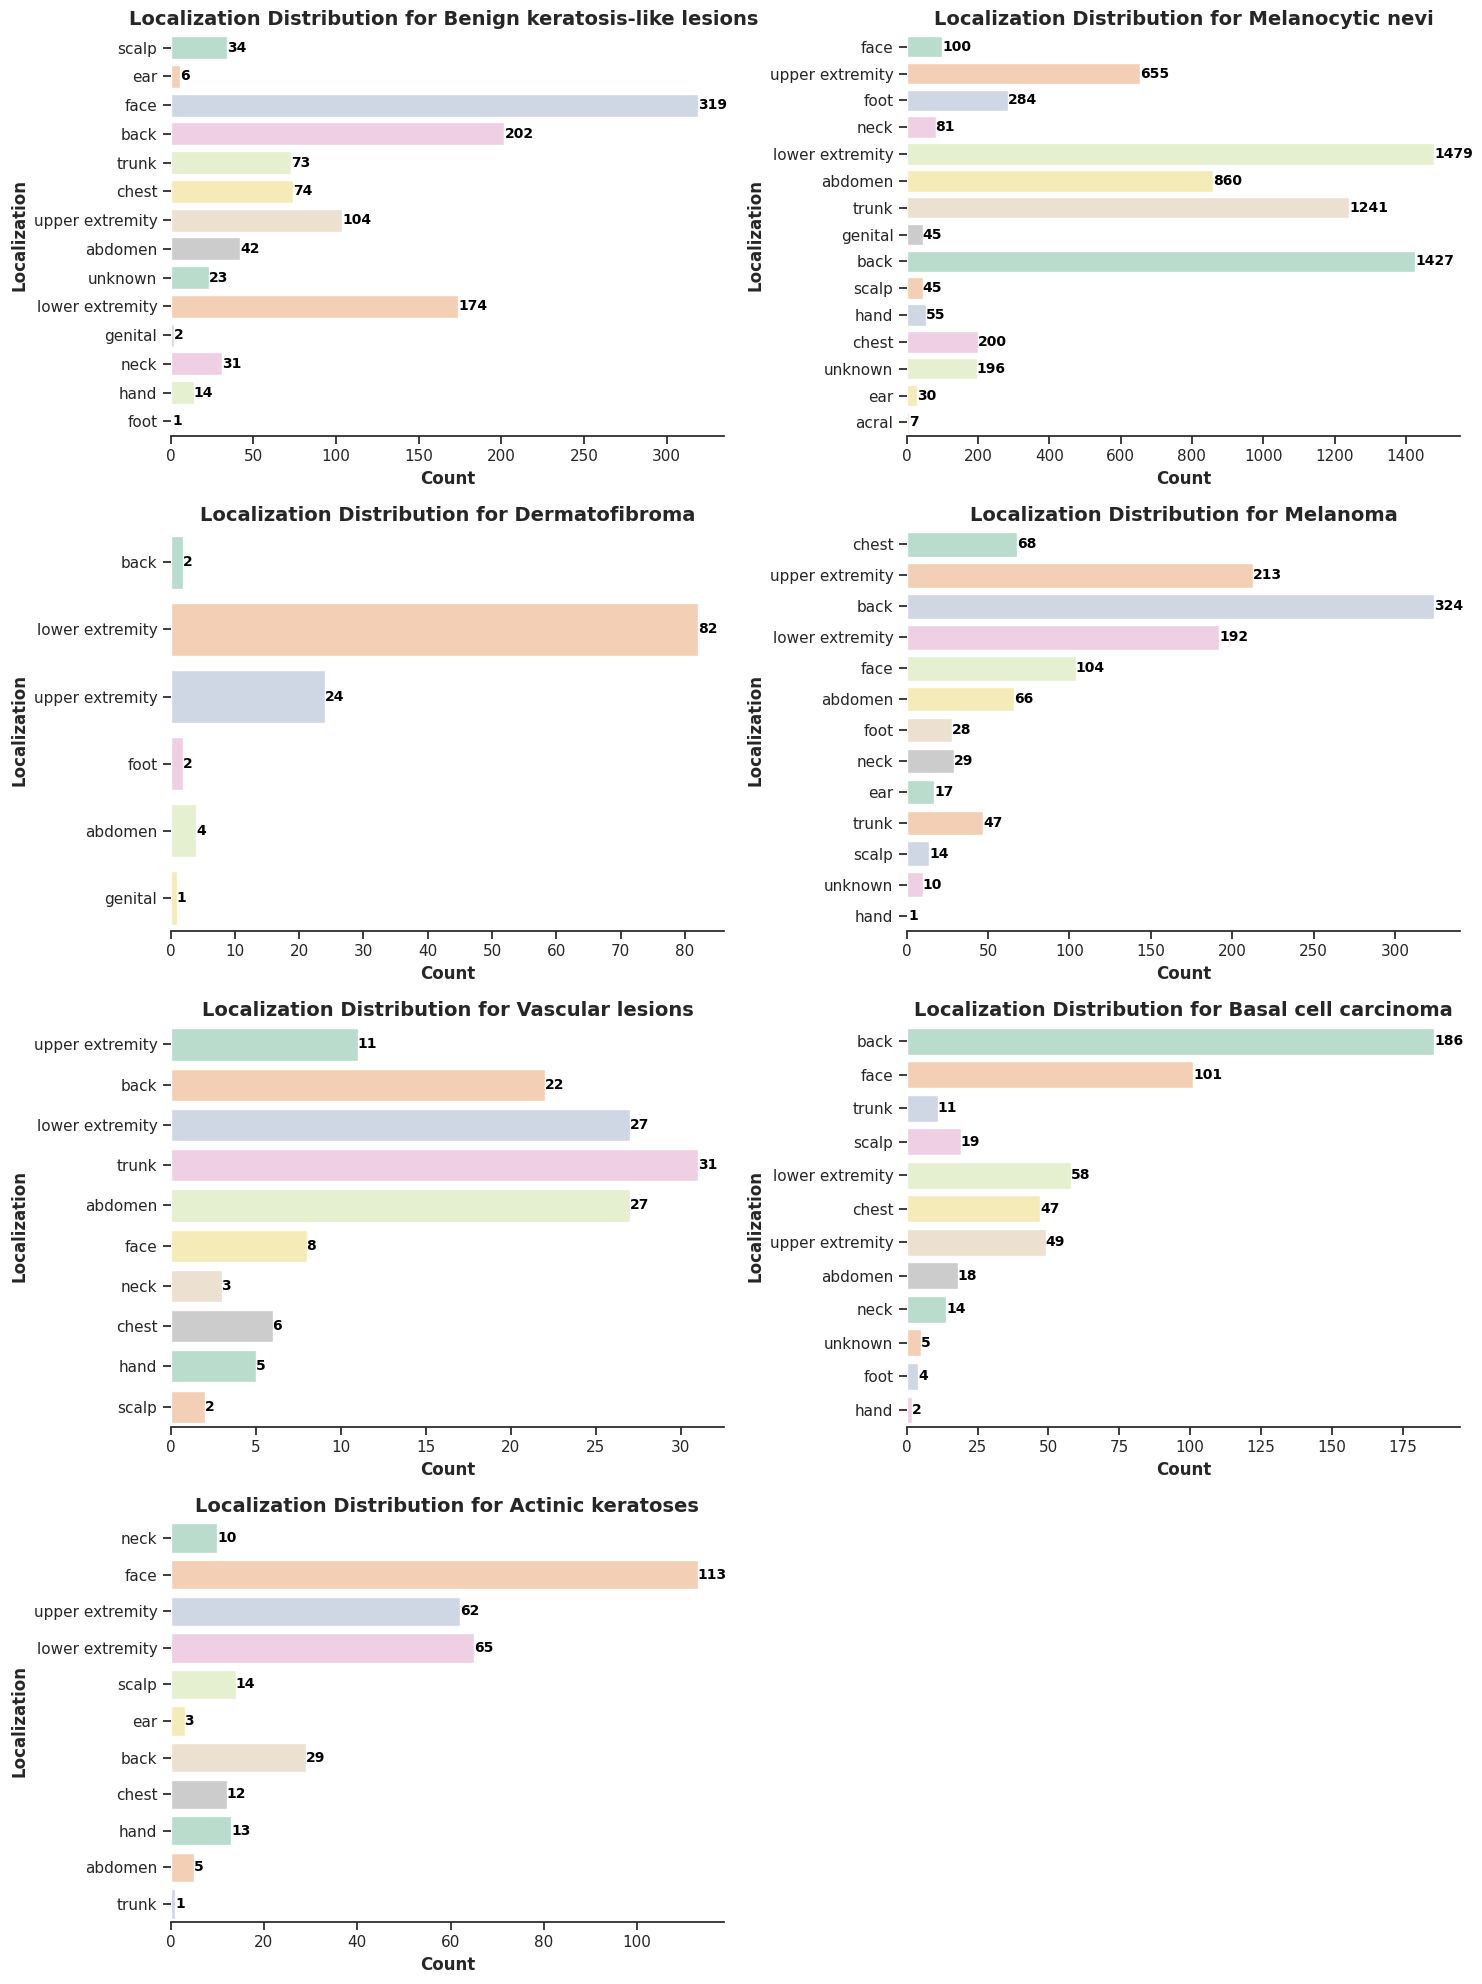

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique cell types
unique_cell_types = skin_df['cell_type'].unique()

# Calculate the number of rows and columns for subplots
num_rows = (len(unique_cell_types) + 1) // 2  # Add 1 to ensure at least one row
num_cols = min(2, len(unique_cell_types))  # Maximum 2 columns

# Set the figure size
plt.figure(figsize=(15, 5 * num_rows))

# Set the style and font scale
sns.set(style="ticks", font_scale=1)

# Iterate through each cell type
for i, cell_type in enumerate(unique_cell_types):
    # Filter data for the current cell type
    data_subset = skin_df[skin_df['cell_type'] == cell_type]

    # Create subplot
    plt.subplot(num_rows, num_cols, i + 1)

    # Create a horizontal bar plot
    ax = sns.countplot(y='localization', hue='localization', data=data_subset, palette='Pastel2', orient='horizontal', legend=False)

    # Add count labels on top of each bar
    for p in ax.patches:
        width = p.get_width()
        ax.text(width, p.get_y() + p.get_height()/2., '{:.0f}'.format(width), ha="left", va="center", fontsize=10, color='black', weight='bold')

    # Remove spines
    sns.despine(top=True, right=True, left=True, bottom=False)

    # Set x-axis and y-axis labels
    ax.set_xlabel('Count', fontsize=12, weight='bold')
    ax.set_ylabel('Localization', fontsize=12, weight='bold')

    # Set title
    plt.title(f'Localization Distribution for {cell_type}', fontsize=14, weight='bold')

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


There’s quite a lot of information, especially since there’s 7 distinct diagnoses and 15 distinct localizations. Some interesting observations:

- For df, dermatofibroma, it seems to exclusively happen on the lower and upper extremity.
- The face seems to be the most prevalent location for akiec and bkl
- Skin lesions in the acral and genital regions are almost always nv
- The back is home to many of the diagnoses, except for df and akiec, both of which have a relatively smaller percentage of examples located there